In [1]:
import numpy as np
import sys
import muram as mio  
import matplotlib.pyplot as plt

In [2]:
# For the SSD data with ch and corona - you can use this path:
pathsource = '/dat/milic/MURaM_enhanced_network/'
path3D = pathsource #+ '3D/'
path2D = pathsource #+ '2D/'

In [3]:
# For the other SSD data, with higher resolution and photospher only, use this path:
#pathsource = '/dat/milic/'
#path3D = pathsource + '3D/3D_full_subdomain/' # Sorry I was rearranging something there
#path2D = pathsource + '2D/'

In [4]:
# IF you used the first one, it's FULL snaps - so use MuramSnap
#cube = mio.MuramSnap(path3D, 0)
# But for the other one, they are so called SUBSNAPS - so you use MuramSubSnap
cube = mio.MuramSnap(path3D, 499000)

In [5]:
cube.available

['rho',
 'vx',
 'vy',
 'vz',
 'eint',
 'Bx',
 'By',
 'Bz',
 'sflx',
 'Temp',
 'Pres',
 'ne',
 'tau']

In [6]:
cube.Temp.shape

(800, 1024, 1024)

In [7]:
# Mean temperature is an interesting one: 
Tmean = np.mean(cube.Temp.transpose(1,2,0), axis=(0,1)) # I could have done this averaging faster, but this is to be more explicit how the axis are rotated

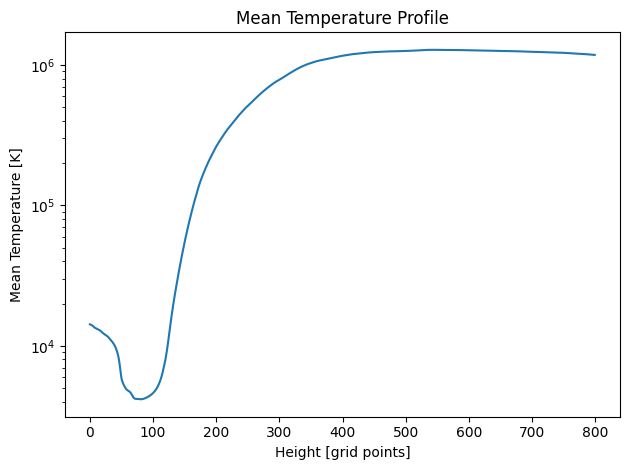

In [8]:
plt.semilogy(Tmean)
plt.xlabel('Height [grid points]')
plt.ylabel('Mean Temperature [K]')
plt.title('Mean Temperature Profile')
plt.tight_layout()
plt.savefig('Tmean_profile.png', dpi=150, bbox_inches='tight')

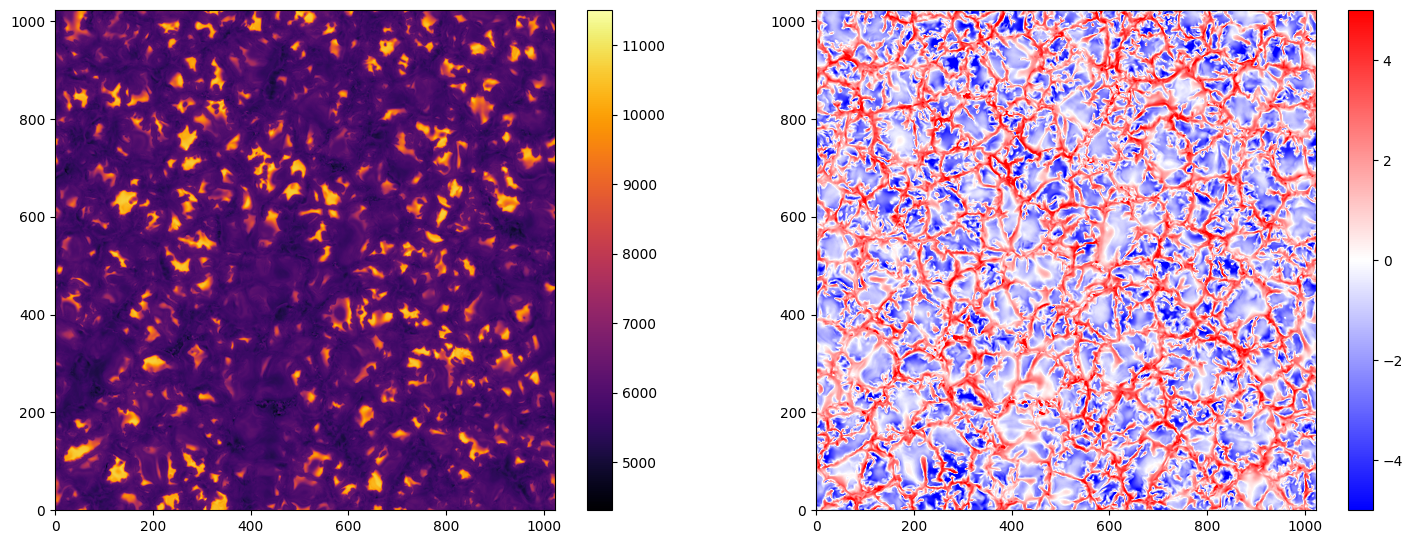

In [9]:
# Taking into account that z is the first axis
# x,y plots:
# Two subpanels, temperature and vz at the bottom:
plt.figure(figsize=(18,6.5))
plt.subplot(1,2,1)
plt.imshow(cube.Temp[49,:,:].T, origin='lower', cmap='inferno')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(-cube.vx[50,:,:].T/1E5, origin='lower', cmap='bwr', vmin=-5, vmax=5)
plt.colorbar()

In [10]:
# Let's check what is this tau variable: 
cube.tau.shape

(800, 1024, 1024)

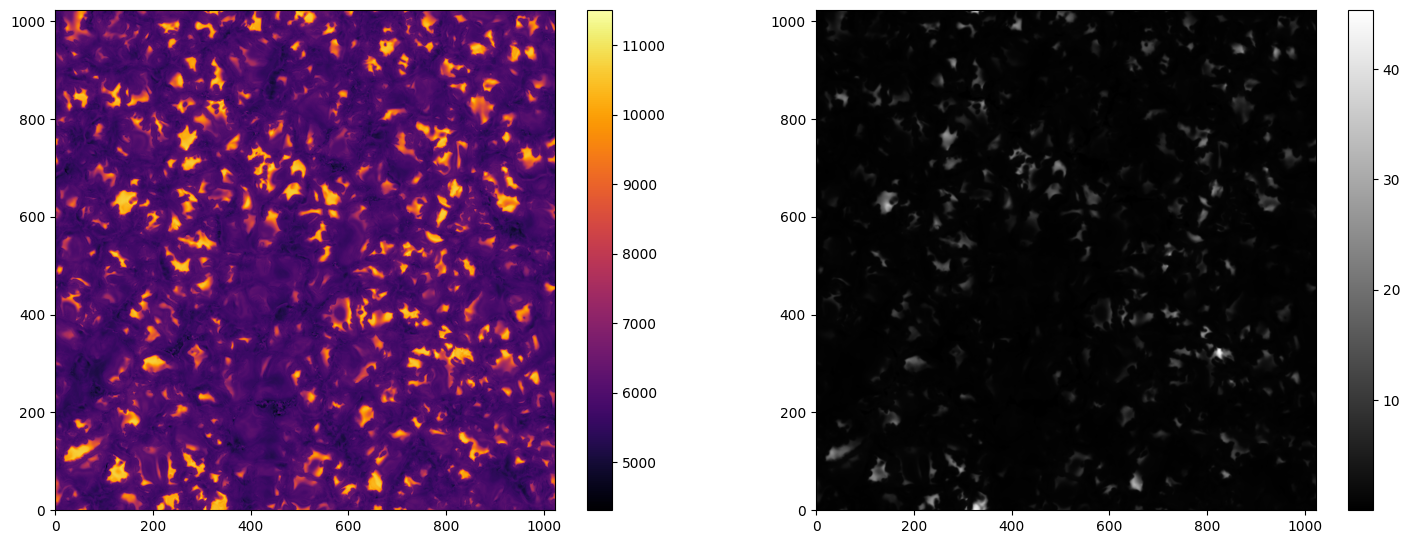

In [11]:
# Taking into account that z is the first axis
# x,y plots:
# Two subpanels, temperature and vz at the bottom:
plt.figure(figsize=(18,6.5))
plt.subplot(1,2,1)
plt.imshow(cube.Temp[49,:,:].T, origin='lower', cmap='inferno')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cube.tau[49,:,:].T, origin='lower', cmap='gray')
plt.colorbar()

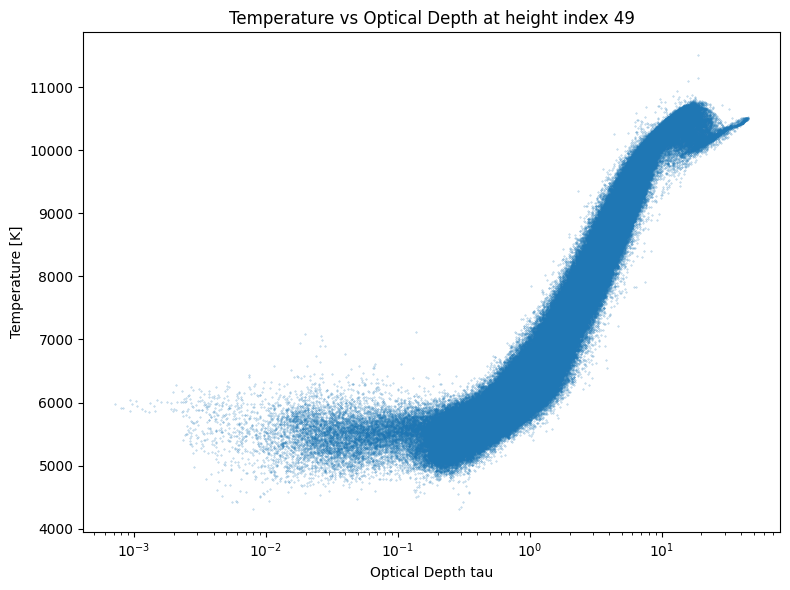

In [12]:
# Scatter plot two study the relation between temperature and tau at a given height
z_index = 49  # height index to study
plt.figure(figsize=(8,6))
plt.scatter(cube.tau[z_index,:,:].flatten(), cube.Temp[z_index,:,:].flatten(), s=0.1, alpha=0.5)
plt.xscale('log')
plt.xlabel('Optical Depth tau')
plt.ylabel('Temperature [K]')
plt.title(f'Temperature vs Optical Depth at height index {z_index}')
plt.tight_layout()

In [20]:
T_photosphere = np.copy(cube.Temp[:70,:,:])
T_photosphere = T_photosphere.transpose(1,2,0)  # Now shape is (x,y,z)

# Same for tau 

tau_photosphere = np.copy(cube.tau[:70,:,:])
tau_photosphere = tau_photosphere.transpose(1,2,0)  # Now shape is (x,y,z)

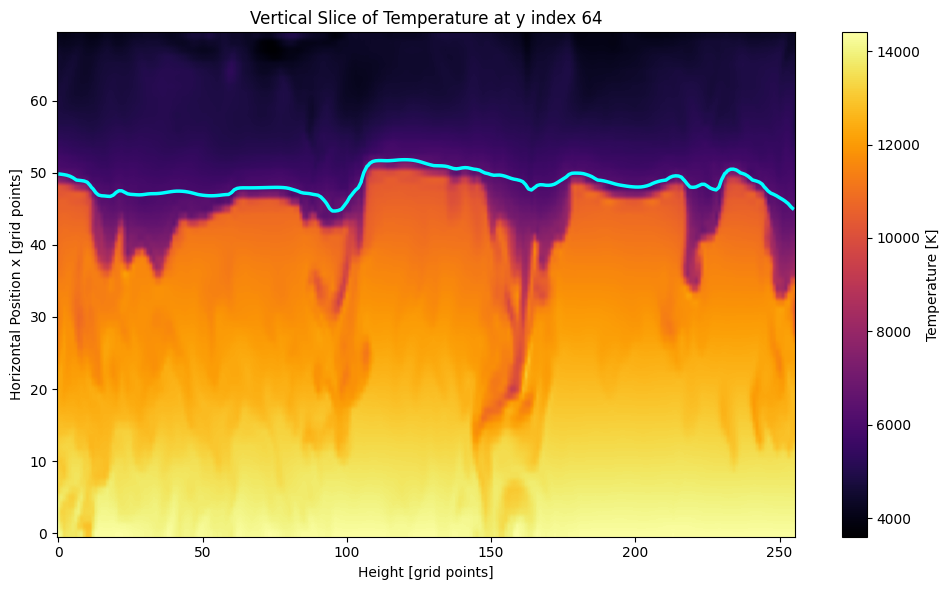

In [22]:
# Let's try and make vertical slice in the atmosphere, to see how temperature varies with height and horizontal position

# Overplot line where tau = =1

y_index = 64  # y index to take the slice
plt.figure(figsize=(10,6))
plt.imshow(T_photosphere[:256,y_index,:].T, origin='lower', aspect='auto', cmap='inferno')

plt.colorbar(label='Temperature [K]')
plt.xlabel('Height [grid points]')
plt.ylabel('Horizontal Position x [grid points]')
plt.title(f'Vertical Slice of Temperature at y index {y_index}')

cs = plt.contour(
    tau_photosphere[:256,y_index,:].T,
    levels=[1.0],        # list of levels
    colors='cyan',          # contour color
    linewidths=2.5
)

#plt.clabel(cs, fmt="%.2f") # optional: label the contour

plt.tight_layout()
plt.savefig('vertical_slice_temperature.png', dpi=150, bbox_inches='tight')

In [25]:
with open('/dat/milic/MURaM_enhanced_network/Header.499000', 'r') as f:
    content = f.read()  # reads entire file as string
print(content)

800  1024  1024  2000000.0  2343750.0  2343750.0 8593.366815 0.005882 300000000.0


In [28]:
# Ok, finally, let's interpolate our cubes onto a fixed iso-tau grid. 
from tqdm import tqdm

tau_values = np.array([1.0,0.1,0.01,0.001])

# Now interpolate:
from scipy.interpolate import interp1d
T_iso_tau = np.zeros((T_photosphere.shape[0], T_photosphere.shape[1], len(tau_values)))
for i in tqdm(range(T_photosphere.shape[0])):  # over x
    for j in range(T_photosphere.shape[1]):  # over y
        f = interp1d(tau_photosphere[i,j,:], T_photosphere[i,j,:], bounds_error=False, fill_value="extrapolate")
        T_iso_tau[i,j,:] = f(tau_values)

100%|██████████| 1024/1024 [01:04<00:00, 15.79it/s]


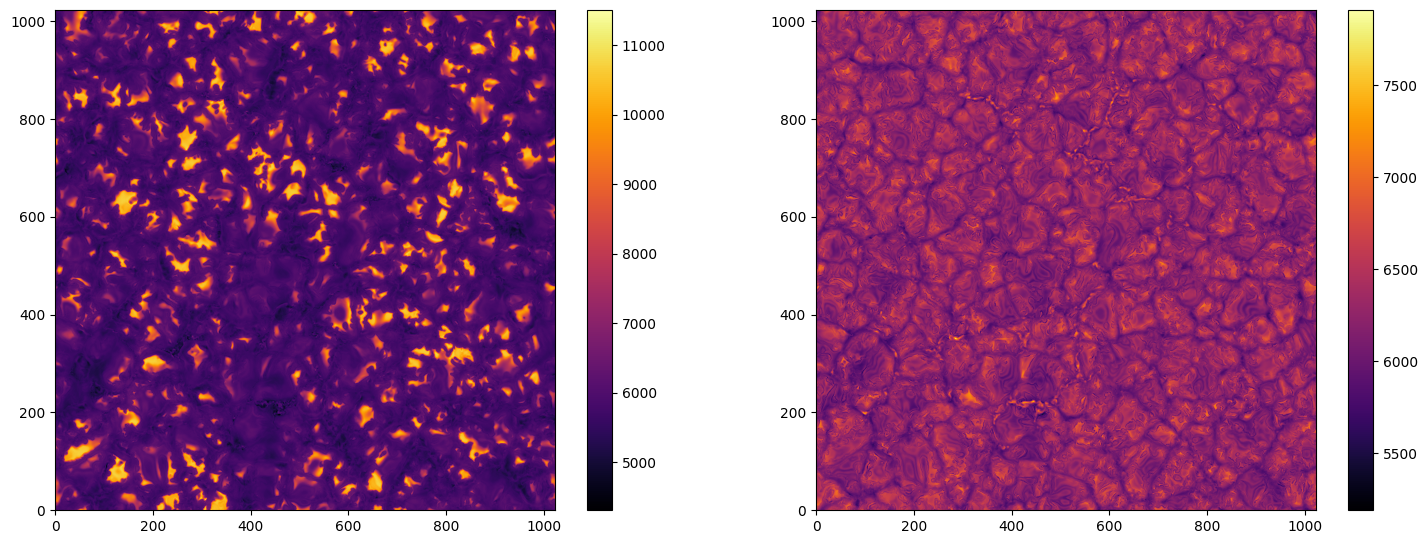

In [33]:
# Taking into account that z is the first axis
# x,y plots:
# Two subpanels, temperature and vz at the bottom:
plt.figure(figsize=(18,6.5))
plt.subplot(1,2,1)
plt.imshow(cube.Temp[49,:,:].T, origin='lower', cmap='inferno')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(T_iso_tau[:,:,0].T, origin='lower', cmap='inferno')
plt.colorbar()